Overall intended workflow for Abidjan flood detection. Based on process established by Huang et al. (2015)
    - Import DG image downloaded from GBDX platform
    - Convert geotiff files to numpy array via rasterio
    - Scale to surface reflectance values (divide by 10,000)
    - Define individual bands for later calculations
    - Calculate indices (NDVI, multiple versions of NDWI) and dark parameter
    - Threshold and plot based on Cloud to Street algorithm
    - Calculate MSI 
    - Threshold and plot NDVI, NDWI and MSI
    - Compare output to Cloud-to-Street results
    - Segment final image 
    - Identify characteristics of objects (area, shape, density, length:width ratio, homogeneity)

**References**
Huang, X., Xie, C., Fang, X., Zhang, L. Combining Pixel-and Object-Based Machine Learning for Identification of Water-Body Types from Urban High-Resolution Remote-Sensing Imagery. IEEE J. Sel. Top. Appl. Earth Obs. Remote Sens. 2015, 8, 2097–2110.

Cloud to Street. Urban Flood Mapping Using Very-High Resolution Satellite Imagery. Available at: https://abidjan.cloudtostreet.info/info

This notebook calculates and plots NDVI and three different formulations of NDWI as defined within the notebook. Cloud and flood plots are produced based on the algorithm provided by Cloud to Street:

**Final algorithm from Cloud-to-Street for Abidjan image:**

**Clouds:**

C ≥ 0.25 and RE  ≥ 0.25

**Flood:**

(NDWI1 ≥ 0.03, DARK ≤ 5, C ≤ 1, and R ≤ 0.85 ) or *check with Jeff re NDWI1 threshold. replaced with 0.03 for now

(NDWI2 ≥ 0.03, DARK ≤ 5.8, C ≤ 1)

This notebook also calculates the MSI based on Huang et al. (2012). The calculation utilizes the scikit-image blacktop hat package. 

Cloud, MSI and NDWI images are morphologically opened to get rid of small one off pixels.
Opening done via scikit image opening package

In [1]:
%matplotlib inline

In [2]:
# Import necessary packages
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from glob import glob
from skimage.morphology import erosion, dilation, opening, closing, black_tophat
from skimage import draw
from skimage.morphology import disk, diamond
import rasterio as rio
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es


In [3]:
# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics','spring-2019', 'flood-detection'))
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

### Update band_path with directory for imagery of interest

In [4]:
aoi = "bietry_ps"
band_path = os.path.join("dg-data", aoi +"\\")
all_dg_bands = glob(band_path+"*band_*")
all_dg_bands.sort()
outputs_path = os.path.join(band_path, "outputs\\")

In [5]:
# Create raster stack of all bands
all_bands_path = os.path.join(outputs_path, aoi + "_all_bands.tif")
all_bands, all_bands_meta = es.stack(all_dg_bands,
                                             all_bands_path)

In [6]:
# Open raster stack
with rio.open(all_bands_path) as src:
    all_bands_stack = src.read()
    all_bands_stack_meta = src.profile
    files_out_meta = src.profile
    masks_out_meta = src.profile

In [7]:
# Update files out meta for writing out single files
files_out_meta['count']=1
# Update masks_out_meta for writing single integer type files
masks_out_meta['dtype'] = 'int32'
masks_out_meta['count'] = 1

In [8]:
# Scale raster stack to surface reflectance values (should be between 0 and 1)
all_bands_scaled = all_bands_stack/10000

In [9]:
# Commented out due to memory issues
# # Plot histogram to explore scaled value distribution 
# fig,ax = plt.subplots()
# plt.hist(all_bands_scaled.ravel(), bins='auto');

In [10]:
# Check for max scaled values 
# print(all_bands_scaled[7].max(), all_bands_stack[7].max())

In [11]:
# Commented out due to memory issues
#Plot one band to take quick look at image
# fig,ax = plt.subplots()
# plt.imshow(all_bands_scaled[0])

In [12]:
# Read in scaled bands
coastal_scaled = all_bands_scaled[0]
blue_scaled = all_bands_scaled[1]
green_scaled = all_bands_scaled[2]
yellow_scaled = all_bands_scaled[3]
red_scaled = all_bands_scaled[4]
rededge_scaled = all_bands_scaled[5]
nearir1_scaled = all_bands_scaled[6]
nearir2_scaled = all_bands_scaled[7]

In [13]:
# Calculate NDWI values
# NDWI0 = (G-NIR1)/(G+NIR1) - McFeeters (1996) 
# NDWI1 = (C - NIR2)/(C + NIR2)
# NDWI2 = (Y - NIR2) / (Y + NIR2); DARK = RE+NIR1+NIR2
ndwi0 = es.normalized_diff(b1=green_scaled, b2=nearir1_scaled)  
ndwi1 = es.normalized_diff(b1=coastal_scaled, b2=nearir2_scaled)
ndwi2 = es.normalized_diff(b1= yellow_scaled, b2=nearir2_scaled)

In [14]:
# Compare mean NDWI values 
mean_ndwi0 = np.nanmean(ndwi0)
mean_ndwi1 = np.nanmean(ndwi1)
mean_ndwi2 = np.nanmean(ndwi2)
print("NDWI0:",mean_ndwi0, "NDWI1:", mean_ndwi1, "NDWI2:", mean_ndwi2)

NDWI0: -0.22646734 NDWI1: -0.34492263 NDWI2: -0.21080281


In [15]:
# # Plot NDWI0
# fig, ax = plt.subplots(figsize=(20,10))
# ndwi0_plot = ax.imshow(ndwi0, cmap='RdBu',
#                 vmin=-1, vmax=1)
# fig.colorbar(ndwi0_plot, fraction=.05)
# ax.set(title="NDWI0, June 17, 2016\n"+aoi+"\n")
# ax.set_axis_off()
# plt.show()

In [16]:
# # Plot NDWI1
# fig, ax = plt.subplots(figsize=(20,10))
# ndwi1_plot = ax.imshow(ndwi1, cmap='RdBu',
#                 vmin=-1, vmax=1)
# fig.colorbar(ndwi1_plot, fraction=.05)
# ax.set(title="NDWI1, June 17, 2016\n"+aoi+"\n")
# ax.set_axis_off()
# plt.show()

In [17]:
# # Plot NDWI2
# fig, ax = plt.subplots(figsize=(20,10))
# ndwi2_plot = ax.imshow(ndwi2, cmap='RdBu',
#                 vmin=-1, vmax=1)
# fig.colorbar(ndwi2_plot, fraction=.05)
# ax.set(title="NDWI2, June 17, 2016\n"+aoi+"\n")
# ax.set_axis_off()
# plt.show()

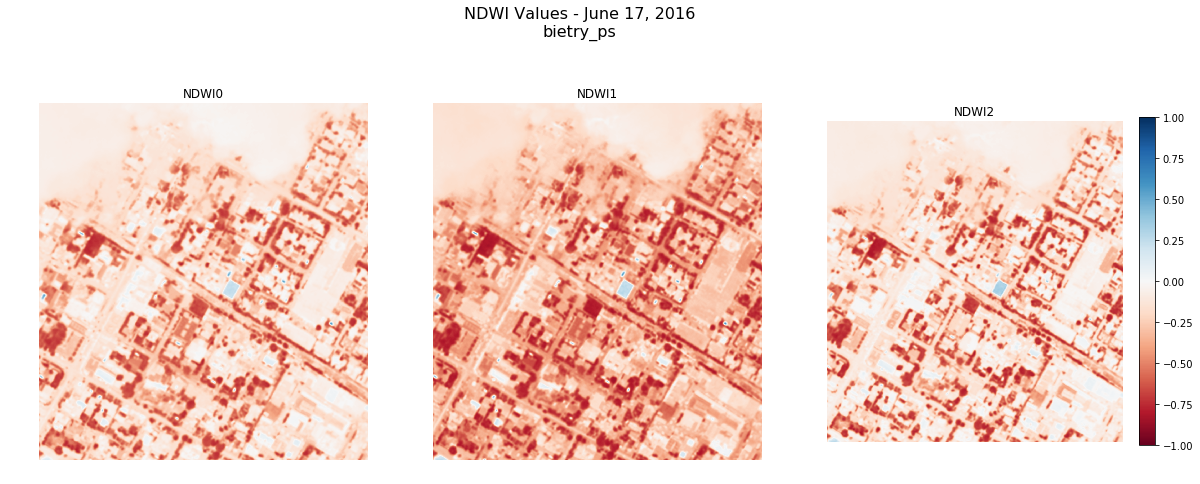

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

plt.suptitle('NDWI Values - June 17, 2016\n'+aoi+"\n", fontsize=16)

ndwi0_plot = ax1.imshow(ndwi0, cmap='RdBu',vmin=-1, vmax=1)
fig.colorbar(ndwi0_plot, fraction=.05)
ax1.set(title="NDWI0")
ax1.set_axis_off()

ndwi1_plot = ax2.imshow(ndwi1, cmap='RdBu',vmin=-1, vmax=1)
ax2.set(title="NDWI1")
ax2.set_axis_off()
                        
ndwi2_plot = ax3.imshow(ndwi2, cmap='RdBu',vmin=-1, vmax=1)
ax3.set(title="NDWI2")
ax3.set_axis_off()

In [19]:
# Calculate DARK parameter
dark = (rededge_scaled + nearir1_scaled + nearir2_scaled)

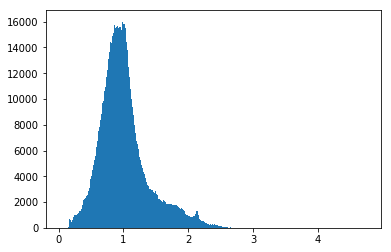

In [20]:
# Plot histogram to explore scaled value distribution 
fig,ax = plt.subplots()
plt.hist(dark.ravel(), bins='auto');

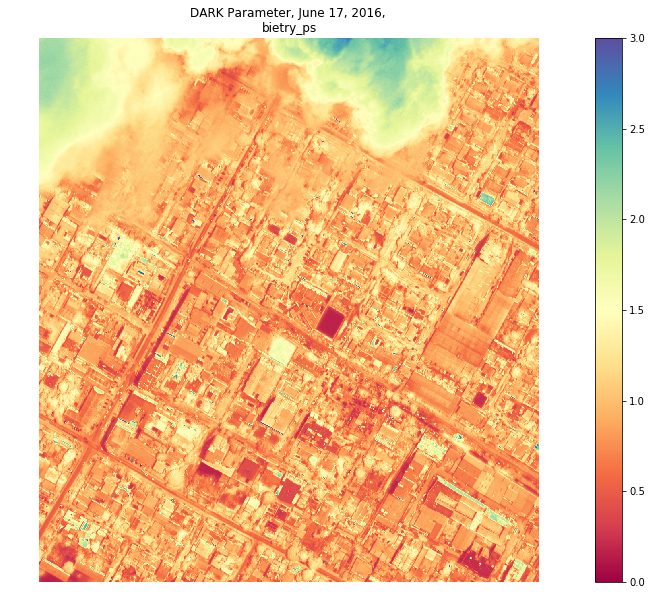

In [21]:
# Plot DARK parameter
fig, ax = plt.subplots(figsize=(20,10))
dark_plot = ax.imshow(dark, cmap='Spectral',
                vmin=0, vmax=3)
fig.colorbar(dark_plot, fraction=.05)
ax.set(title="DARK Parameter, June 17, 2016, \n"+aoi)
ax.set_axis_off()
plt.show()

In [22]:
# Calculate NDVI (NIR1 - R)/(NIR1 + R)
ndvi = es.normalized_diff(b1=nearir1_scaled, b2= red_scaled) 

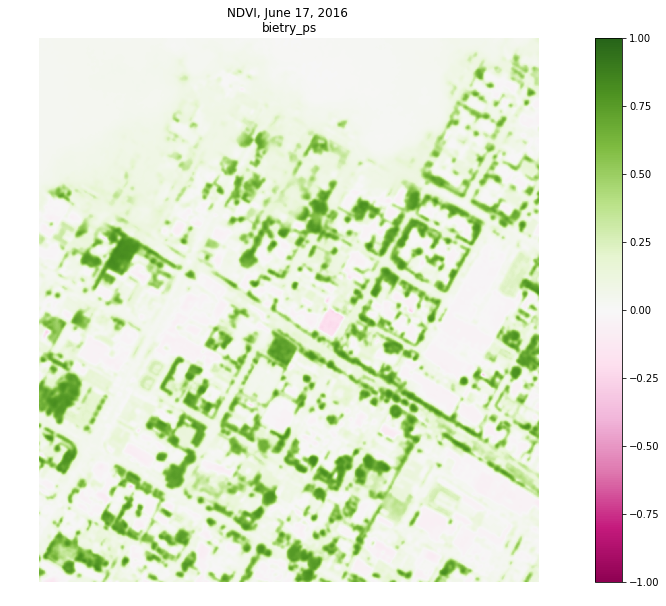

In [23]:
# Plot NDVI
fig, ax = plt.subplots(figsize=(20,10))
ndvi_plot = ax.imshow(ndvi, cmap='PiYG',
                vmin=-1, vmax=1)
fig.colorbar(ndvi_plot, fraction=.05)
ax.set(title="NDVI, June 17, 2016 \n" +aoi)
ax.set_axis_off()
plt.show()

In [24]:
# fig,ax = plt.subplots(figsize=(20, 10))

# plt.suptitle('NDWI Histogram - June 17, 2016 - Cote D-Ivoire', fontsize=16)

# ndwi0_hist = plt.hist(ndwi0.ravel(), bins='auto');
# ax1.set(title="NDWI0")
# ax1.set_axis_off()

# ndwi1_hist = plt.hist(ndwi1.ravel(), bins='auto');
# ax2.set(title="NDWI1")
# ax2.set_axis_off()
                        
# ndwi2_hist = plt.hist(ndwi2.ravel(), bins='auto');
# ax3.set(title="NDWI2")
# ax3.set_axis_off()

In [25]:
# fig,ax = plt.subplots(figsize=(20, 10))

# plt.suptitle('NDWI Histogram - June 17, 2016 - Cote D-Ivoire', fontsize=16)

# ndwi0_hist = plt.hist(ndwi0.ravel(), bins='auto');
# ax.set(title="NDWI0")
# ax.set_axis_off()

In [26]:
# Calculate cloud mask layer based on Cloud to Street thresholds
cloud = ((coastal_scaled >= 0.25) & (rededge_scaled >= 0.25)).astype(int)

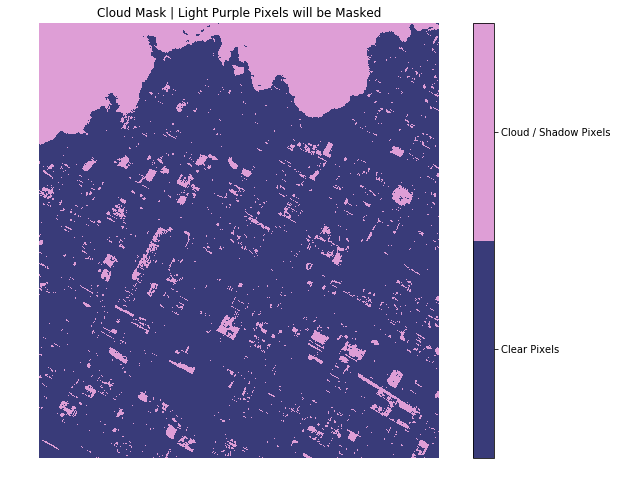

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(cloud,
               cmap=plt.cm.get_cmap('tab20b', 2))
cbar = fig.colorbar(im)
cbar.set_ticks((0.25, .75))
cbar.ax.set_yticklabels(["Clear Pixels", "Cloud / Shadow Pixels"])
ax.set_title("Cloud Mask | Light Purple Pixels will be Masked")
ax.set_axis_off()
plt.show()

In [28]:
# Trial with erosion to get rid of areas identified in cloud mask which are not actually cloud
selem = disk(10)
cloud_eroded = erosion(cloud, selem)

In [29]:
# Trial with opening to get rid of areas identified in cloud mask which are not actually cloud
selem = disk(15)
cloud_opened = opening(cloud, selem)

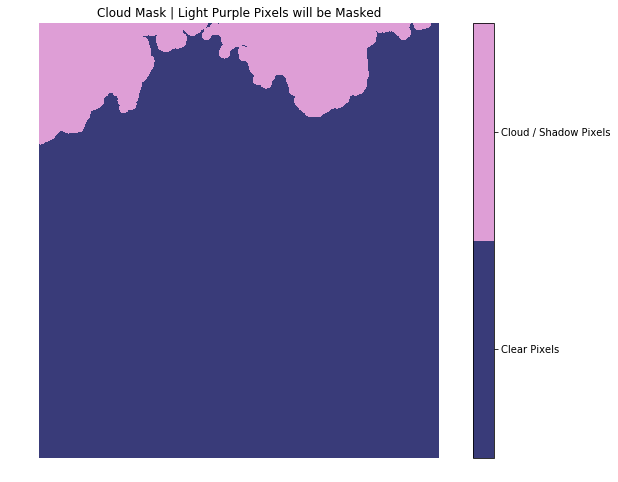

In [30]:
#Plot opened cloud mask
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(cloud_opened,
               cmap=plt.cm.get_cmap('tab20b', 2))
cbar = fig.colorbar(im)
cbar.set_ticks((0.25, .75))
cbar.ax.set_yticklabels(["Clear Pixels", "Cloud / Shadow Pixels"])
ax.set_title("Cloud Mask | Light Purple Pixels will be Masked")
ax.set_axis_off()
plt.show()

In [31]:
# Apply cloud mask to all_bands_scaled stack
cloud_mask = np.broadcast_to(cloud_opened == 1, all_bands_scaled.shape)
all_bands_cl_free = ma.masked_array(all_bands_scaled,
                                      mask=cloud_mask)

In [32]:
# Define cloud masked scaled bands
coastal_cl_free = all_bands_cl_free[0]
blue_cl_free = all_bands_cl_free[1]
green_cl_free = all_bands_cl_free[2]
yellow_cl_free = all_bands_cl_free[3]
red_cl_free = all_bands_cl_free[4]
rededge_cl_free = all_bands_cl_free[5]
nearir1_cl_free = all_bands_cl_free[6]
nearir2_cl_free = all_bands_cl_free[7]

In [33]:
# Calculated NDWI, NDVI and dark parameter for cloud masked bands
ndwi0_cl_free = es.normalized_diff(b1=green_cl_free, b2=nearir1_cl_free)  
ndwi1_cl_free = es.normalized_diff(b1=coastal_cl_free, b2=nearir2_cl_free)
ndwi2_cl_free = es.normalized_diff(b1= yellow_cl_free, b2=nearir2_cl_free)
ndvi_cl_free = es.normalized_diff(b1=nearir1_cl_free, b2= red_cl_free)
dark_cl_free = rededge_cl_free+nearir1_cl_free+nearir2_cl_free

In [34]:
# Compare mean NDWI values 
mean_ndwi0_cl_free = np.nanmean(ndwi0_cl_free)
mean_ndwi1_cl_free = np.nanmean(ndwi1_cl_free)
mean_ndwi2_cl_free = np.nanmean(ndwi2_cl_free)

print("NDWI0_cl_free:",mean_ndwi0_cl_free, "NDWI1_cl_free:", mean_ndwi1_cl_free, "NDWI2_cl_free:", mean_ndwi2_cl_free)
print("NDWI0:",mean_ndwi0, "NDWI1:", mean_ndwi1, "NDWI2:", mean_ndwi2)

NDWI0_cl_free: -0.25040966 NDWI1_cl_free: -0.37677538 NDWI2_cl_free: -0.23035133
NDWI0: -0.22646734 NDWI1: -0.34492263 NDWI2: -0.21080281


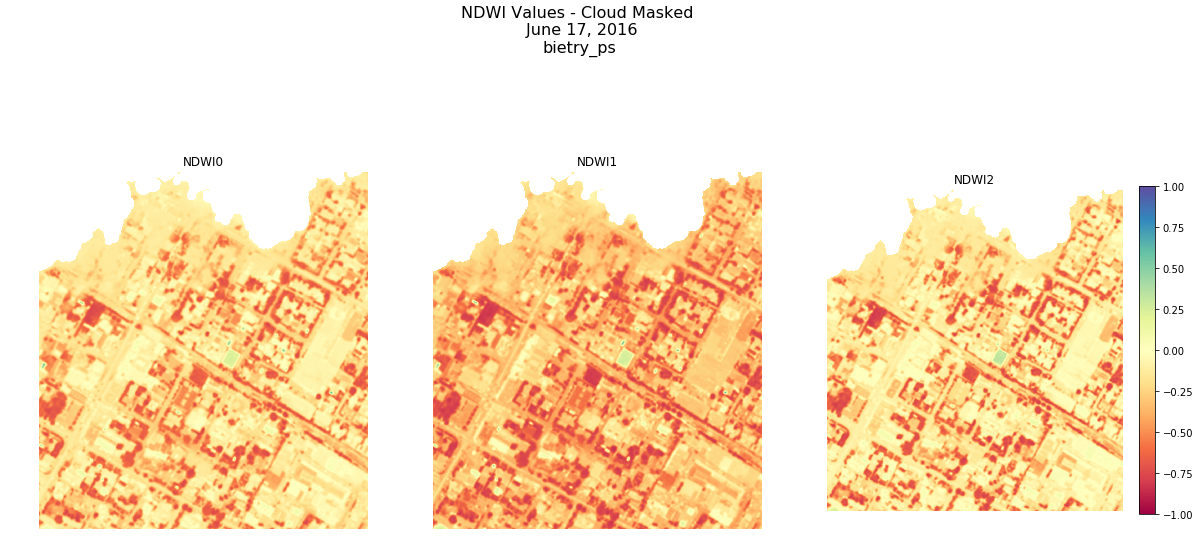

In [35]:
# Plot NDWIs for cloud masked
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plt.suptitle('NDWI Values - Cloud Masked \n June 17, 2016\n'+aoi, fontsize=16)

ndwi0_cl_free_plot = ax1.imshow(ndwi0_cl_free, cmap='Spectral',vmin=-1, vmax=1)
fig.colorbar(ndwi0_cl_free_plot, fraction=.05)
ax1.set(title="NDWI0")
ax1.set_axis_off()

ndwi1_cl_free_plot = ax2.imshow(ndwi1_cl_free, cmap='Spectral',vmin=-1, vmax=1)
ax2.set(title="NDWI1")
ax2.set_axis_off()
                        
ndwi2_cl_free_plot = ax3.imshow(ndwi2_cl_free, cmap='Spectral',vmin=-1, vmax=1)
ax3.set(title="NDWI2")
ax3.set_axis_off()

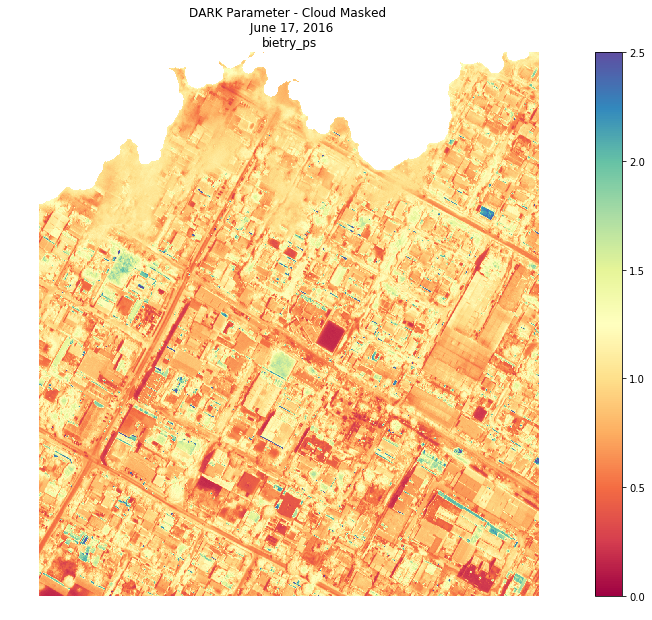

In [36]:
# Plot DARK parameter
fig, ax = plt.subplots(figsize=(20,10))
dark_cl_free_plot = ax.imshow(dark_cl_free, cmap='Spectral',
                vmin=0, vmax=2.5)
fig.colorbar(dark_cl_free_plot, fraction=.05)
ax.set(title="DARK Parameter - Cloud Masked \n June 17, 2016\n"+aoi)
ax.set_axis_off()
plt.show()

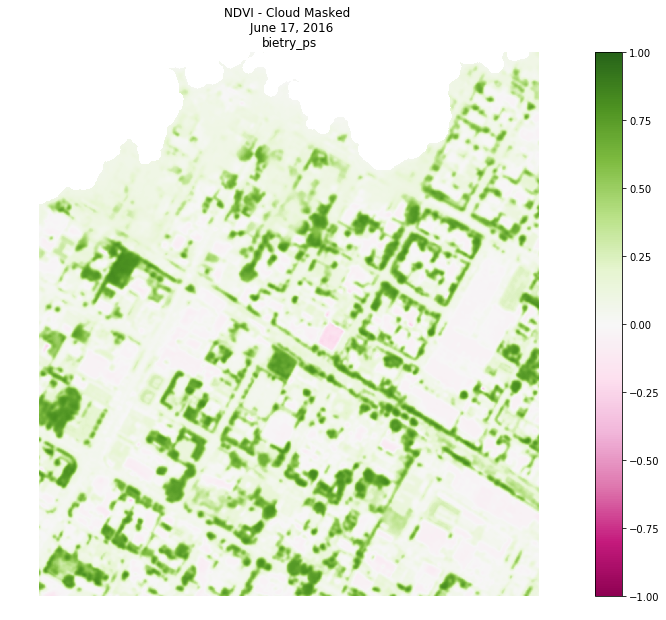

In [37]:
# Plot NDVI parameter
fig, ax = plt.subplots(figsize=(20,10))
ndvi_cl_free_plot = ax.imshow(ndvi_cl_free, cmap='PiYG',
                vmin=-1, vmax=1)
fig.colorbar(ndvi_cl_free_plot, fraction=.05)
ax.set(title="NDVI - Cloud Masked \n June 17, 2016\n"+aoi)
ax.set_axis_off()
plt.show()

In [38]:
print(ndwi1_cl_free.min(), ndwi1_cl_free.max())
print(dark_cl_free.min(), dark_cl_free.max())
print(coastal_cl_free.min(), coastal_cl_free.max())
print(red_cl_free.min(), red_cl_free.max())

-0.8464065 0.61476403
0.0342 4.7361
0.0077 1.2489
0.0107 1.2244


In [39]:
# Write out tif files for ndwi, ndvi, dark files_out_meta = all_bands_meta 
files_out_meta = all_bands_meta
files_out_meta['count']=1
files_out_meta['nodata']=-9999

with rio.open('ndwi0_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi0_cl_free, 1)
with rio.open('ndwi1_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi1_cl_free, 1)
with rio.open('ndwi2_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi2_cl_free, 1)
with rio.open('ndvi_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(ndvi_cl_free, 1)
with rio.open('dark_'+aoi+'.tif', 'w', **files_out_meta) as dst:
    dst.write(dark_cl_free, 1)

### Question for Jeff - where in image are dark values the max. for this subset, dark is always <5

In [40]:
# Calculate paramters for Cloud to Street algorithm
# Flood1 is for NDWI1 and Flood2 is for NDWI2
flood1_cl_free = ((ndwi1_cl_free >= -0.05) & (dark_cl_free <= 5) & (coastal_cl_free <= 1) & (red_cl_free <= 0.85)).astype(int)
flood2_cl_free = ((ndwi2_cl_free >= 0.03) & (dark_cl_free <= 5.8) & (coastal_cl_free <= 1)).astype(int)

In [41]:
# Combine flood1 and flood 2
flood_combo = np.where(flood1_cl_free==1, 1, np.where((flood1_cl_free==1)&(flood2_cl_free==1), 2, np.where(flood2_cl_free>=1, 1, 0)))

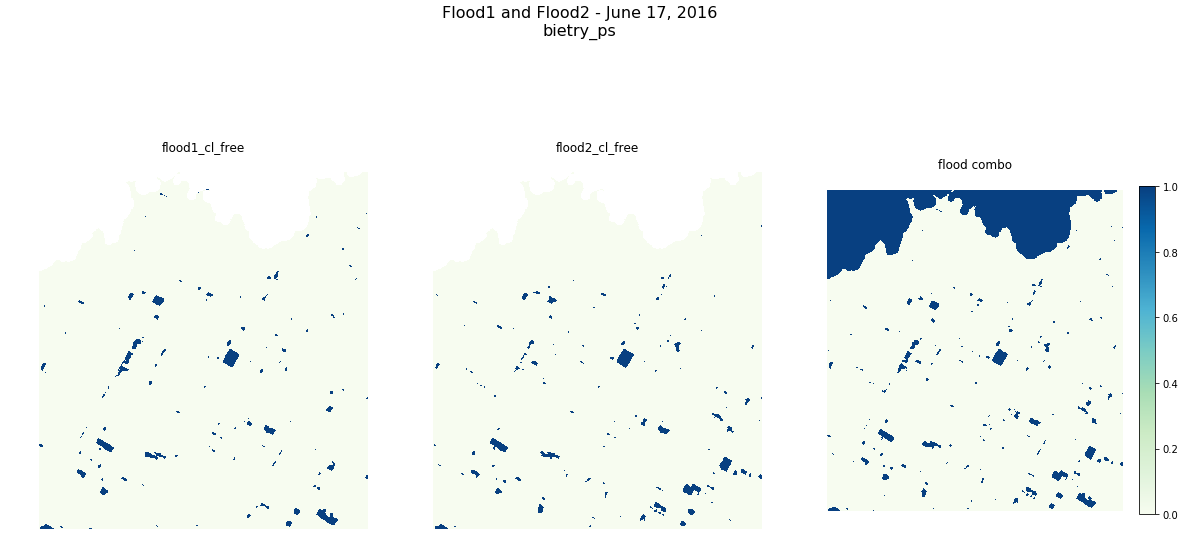

In [42]:
#Plot Flood1, Flood2 and Flood Combo
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))

plt.suptitle('Flood1 and Flood2 - June 17, 2016\n'+aoi, fontsize=16)

flood1_cl_free_plot = ax1.imshow(flood1_cl_free, cmap='GnBu',vmin=0, vmax=1)
fig.colorbar(flood1_cl_free_plot, fraction=.05)
ax1.set(title="flood1_cl_free\n")
ax1.set_axis_off()

flood2_cl_free_plot = ax2.imshow(flood2_cl_free, cmap='GnBu',vmin=0, vmax=1)
ax2.set(title="flood2_cl_free\n")
ax2.set_axis_off() 

flood_combo_plot = ax3.imshow(flood_combo, cmap='GnBu',vmin=0, vmax=1)
ax3.set(title="flood combo\n")
ax3.set_axis_off() 

### How to make combo stay masked?

In [43]:
# Write out flood mask files
with rio.open('flood1_cl_free_'+aoi+'.tif', 'w', **masks_out_meta) as dst:
    dst.write(flood1_cl_free, 1)
with rio.open('flood2_cl_free_'+aoi+'.tif', 'w', **masks_out_meta) as dst:
    dst.write(flood2_cl_free, 1)
with rio.open('flood_combo_cl_free_'+aoi+'.tif', 'w', **masks_out_meta) as dst:
    dst.write(flood_combo, 1)

## Calculate MSI 

In [44]:
# Function for calculating the linear structuring element
def selemline(length, theta, dtype=np.uint8):
    """Line structuring element"""
    theta_d = theta * np.pi / 180
    X = int(round((length-1)/2. * np.cos(theta_d)))
    Y = int(-round((length-1)/2. * np.sin(theta_d)))
    C, R, V = draw.line_aa(-X, -Y, X, Y)
    M = 2*max(abs(R)) + 1
    N = 2*max(abs(C)) + 1
    selem = np.zeros((M, N)).astype(dtype)
    selem[R + max(abs(R)), C + max(abs(C))] = 1
    return selem

In [45]:
# Calculate brightness for cloud masked stack
brightness = all_bands_cl_free.max(axis=0)
print(brightness.max(), brightness.min())

1.8552 0.0119


In [46]:
# Cap brightness values at a max of 1. Replace all values greater than 1 with a value of 1
brightness_cap = brightness
np.place(brightness_cap, brightness_cap > 1, 1)
print(brightness_cap.max(), brightness_cap.min())

1.0 0.0119


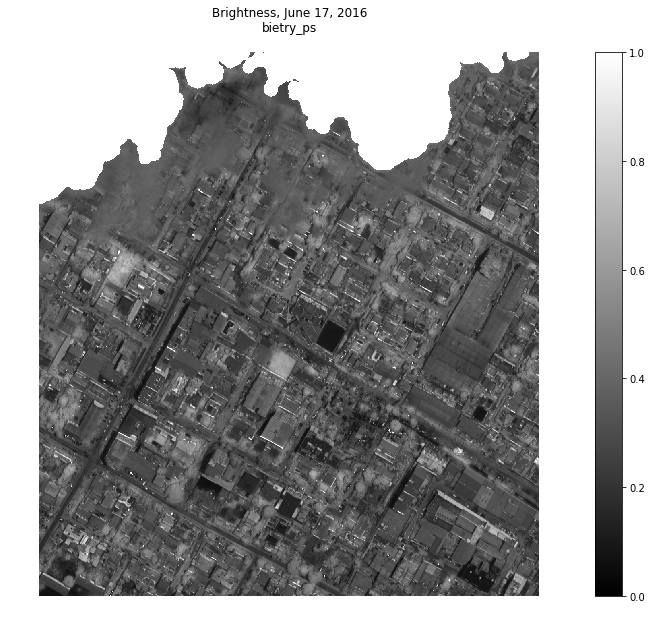

In [47]:
# Plot brightness_cap image
fig, ax = plt.subplots(figsize=(20,10))
brightness_plot = ax.imshow(brightness_cap, cmap='gray',
                vmin=0, vmax=1)
fig.colorbar(brightness_plot, fraction=.05)
ax.set(title="Brightness, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

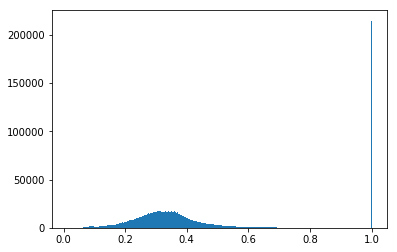

In [48]:
# Plot histogram to explore distribution of brightness_cap values
fig,ax = plt.subplots()
plt.hist(brightness.ravel(), bins='auto');

### Question: what is source of brightness value of 1? Is cloud mask interfering?

In [49]:
# Initialize inputs for MSI calculation selem = selemline(0,0)
b_tophat_array_sum = black_tophat(brightness, selem)

In [50]:
# Loop and sum black tophat morphological profiles for MSI calculation
for i in range(2,57,5):
    for x in range(0, 4):
        selem = selemline(i,45*x)
        b_tophat = black_tophat(brightness,selem)
        b_tophat_array_sum = b_tophat_array_sum.__add__(b_tophat)

In [51]:
msi = b_tophat_array_sum/(4*11)
print(msi.max())

0.6435135


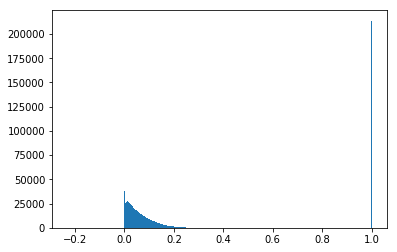

In [52]:
# Plot histogram to explore distribution of MSI values
fig,ax = plt.subplots()
plt.hist(msi.ravel(), bins='auto');

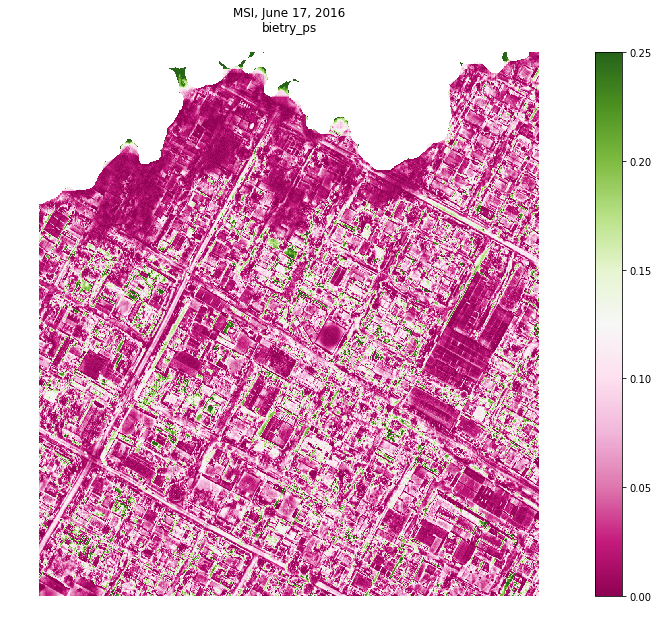

In [53]:
# Plot MSI
fig, ax = plt.subplots(figsize=(20,10))
msi_plot = ax.imshow(msi, cmap='PiYG',
                vmin=0, vmax=0.25)
fig.colorbar(msi_plot, fraction=0.05)
ax.set(title="MSI, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

### Look at suggestions from Jeff to get rid of small pixels of shadow without creating mask
### Use this layer to try ndwi-msi calcs

In [54]:
# Develop shadow mask for MSI > 0.12 and apply morphological opening
shadow = (msi>=0.12).astype(int)
selem_shadow = disk(4)
shadow_opened = opening(shadow, selem_shadow)

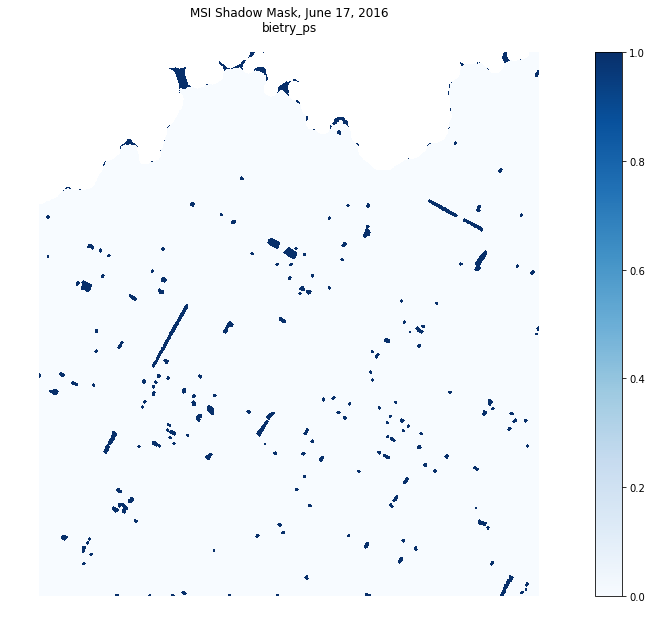

In [55]:
# Plot shadow mask layer 
fig, ax = plt.subplots(figsize=(20,10))
test_plot = ax.imshow(shadow_opened, cmap='Blues',
                vmin=0, vmax=1)
fig.colorbar(test_plot, fraction=.05)
ax.set(title="MSI Shadow Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()

In [56]:
with rio.open('msi_shadow_mask_'+aoi+'.tif', 'w', **masks_out_meta) as dst:
    dst.write(shadow_opened, 1)

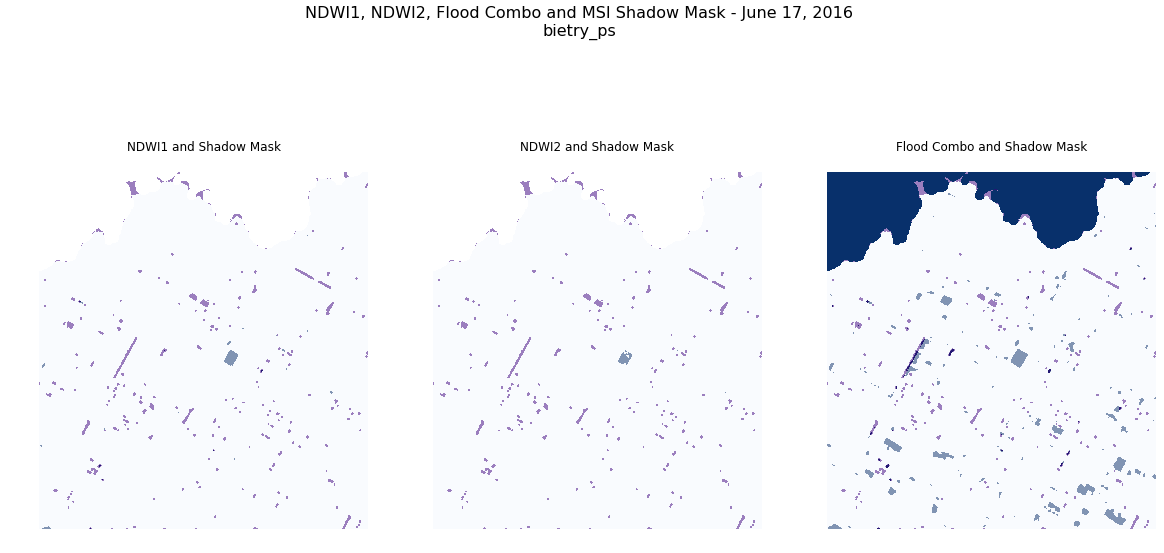

In [57]:
# Compare plots for NDWI1, NDWI2, Flood Combo and MSI Shadow mask
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))

plt.suptitle('NDWI1, NDWI2, Flood Combo and MSI Shadow Mask - June 17, 2016\n'+aoi, fontsize=16)

ndwi1_plot = ax1.imshow(ndwi1_cl_free>=0.2, cmap = 'Blues', vmin = 0, vmax = 1)
msi_plot = ax1.imshow(shadow_opened>=0.12, cmap='Purples', vmin = 0.00, vmax = 0.1, alpha = .5)
ax1.set(title="NDWI1 and Shadow Mask\n")
ax1.set_axis_off()

ndwi2_plot = ax2.imshow(ndwi2_cl_free>=0.3, cmap = 'Blues', vmin = 0, vmax = 1)
msi_plot = ax2.imshow(shadow_opened>=0.12, cmap='Purples', vmin = 0.00, vmax = 0.1, alpha = .5)
ax2.set(title="NDWI2 and Shadow Mask\n")
ax2.set_axis_off() 

flood_combo_plot = ax3.imshow(flood_combo>=1, cmap = 'Blues', vmin = 0, vmax = 1)
msi_plot = ax3.imshow(shadow_opened>=0.12, cmap='Purples', vmin = 0.00, vmax = 0.1, alpha = .5)
ax3.set(title="Flood Combo and Shadow Mask\n")
ax3.set_axis_off()

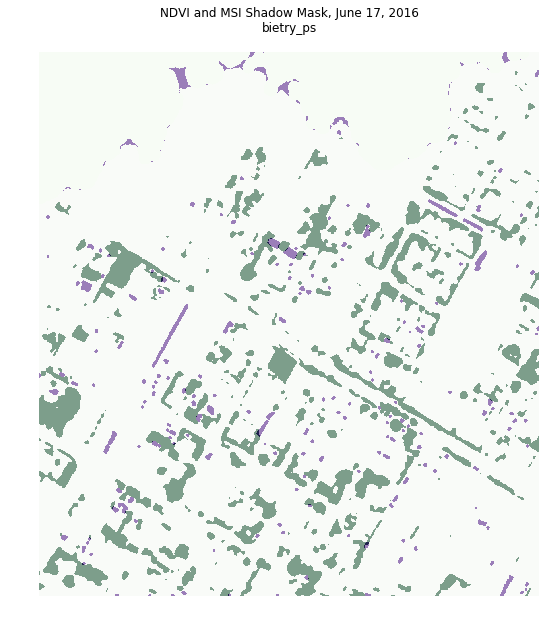

In [58]:
# Plot NDVI & MSI
fig, ax = plt.subplots(figsize=(20,10))
# ndvi_plot = ax.imshow(ndvi_scaled[0]>=20, cmap='Greens')
ndni_plot = ax.imshow(ndvi>.5, cmap = 'Greens', vmin = 0, vmax = 1)
msi_plot = ax.imshow(shadow_opened>=0.12, cmap='Purples', vmin = 0.00, vmax = 0.1, alpha = .5)

ax.set(title="NDVI and MSI Shadow Mask, June 17, 2016\n"+aoi+"\n")
ax.set_axis_off()
plt.show()